In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from neuron import NeuronParam, SimpleNeuron
from synapse import Synapse
from encoding import RF_convolution, encode, RF_kernel
from parameter import TrainParam
from STDP import stdp, stdp_update

In [2]:
T = 150
dt = 1
t_past = -20
t_future = 20


n1 = 28*28 # of neurons in layer 1
n2 = 6 # of neurons in layer 2

wmin=-1.2
wmax=2.
tau_past = 10
tau_future = 10
A_past = 0.3
A_future = 0.8

lr = 0.02

train_param = TrainParam(T = T,
                         dt = dt)
    
neuron_param = NeuronParam(t_refractory = 30,
                           V_rest = 0,
                           V_thr = 50,
                           V_min = -5,
                           V_inhibit = -500,
                           leak = 0.75) 

learning_rule = lambda t : stdp(t,
                                tau_past = tau_past, 
                                tau_future = tau_future, 
                                A_past = A_past, 
                                A_future = A_future)

update = lambda w,dw,scale : stdp_update(w,dw,scale,lr,wmin,wmax)

In [3]:
timeline = np.arange(0,T+dt,dt)
layer = [SimpleNeuron(neuron_param) for _ in range(n2)]
synapse = Synapse(n1,layer)
synapse.random_initialize(0,wmax*0.5)

In [4]:
learn = True
inhibit = True
n_epoch = 30

for epoch in tqdm(range(n_epoch)):
    for num in range(6):
        winner = -1
        if not inhibit:
            #winner = 100
            pass
        
        
        image = cv2.imread(f"data/{num}.png",0)
        image = RF_convolution(image,RF_kernel)
        input_spiketrain = encode(image,train_param)
        adaptation = 1

        synapse.reset_all_neurons()
        
        output_spiketrain = []
        for timestep,t in enumerate(timeline):
            input_spikes = input_spiketrain[:,timestep] # size = (n1, 1)
            result = synapse.run(input_spikes,
                                 t,
                                 scale = adaptation,
                                 lateral_inhibition = (winner == -1))
            
            
            if not result['winner'] == -1:
                winner = result['winner']
                
                
            if learn:
                for out_idx,has_spiked in enumerate(result['output']):
                    if(has_spiked==1): #SPIKE
                        for delta_t in range(-dt-dt,t_past-dt, -dt): #delta_t < 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for in_idx in range(n1):
                                    if input_spiketrain[in_idx,timestep+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[out_idx, in_idx]
                                        assert dw>0
                                        synapse.weight[out_idx, in_idx] = update(w,dw,adaptation) 
                        for delta_t in range(dt+dt,t_future+dt,dt): #delta_t > 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for in_idx in range(n1):
                                    if input_spiketrain[in_idx,timestep+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[out_idx, in_idx]
                                        assert dw<0
                                        synapse.weight[out_idx, in_idx] = update(w,dw,adaptation) 
                                        
            #print("end time")
            
        if winner != -1:
        #if False:
            input_spike_count = np.sum(input_spiketrain,axis=1) == 0
            zero_spike_inputs = np.nonzero(input_spike_count)[0]
            for i in zero_spike_inputs:
                    synapse.weight[winner,i] = \
                    max(synapse.weight[winner,i]-(0.06*adaptation) , wmin)
        #print("end image")
                    
                    
                    
                
            
            

100%|██████████| 30/30 [00:04<00:00,  6.09it/s]


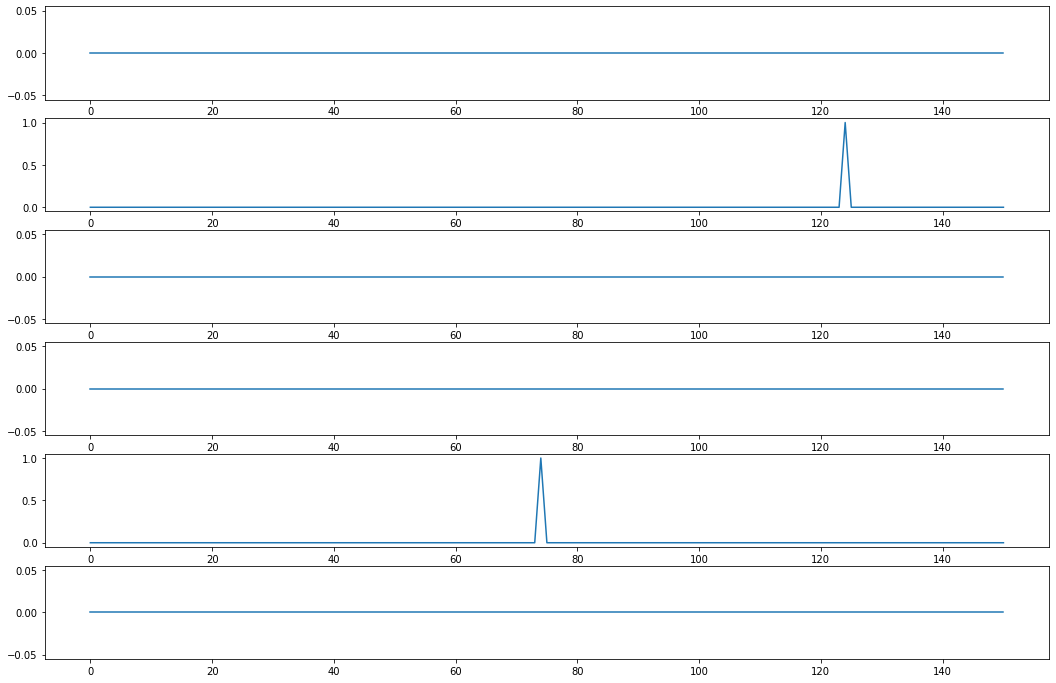

In [5]:
fig = plt.figure(figsize=(18,n2*2))
for i in range(n2):
    fig.add_subplot(n2,1,i+1)
    plt.plot(synapse.post_neurons[i].spike_history)

plt.show()

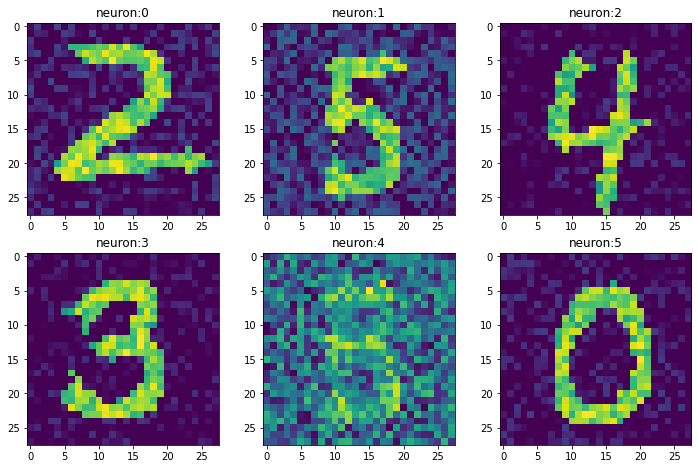

1.130236186232583 -1.2


In [6]:
fig = plt.figure(figsize=(12,12))
axes = []
row = 3
col = n2//row + 1
max_ = np.max(synapse.weight)
min_ = np.min(synapse.weight)
for num in range(n2):
    learned_img = np.interp(synapse.weight[num,:].reshape(int(np.sqrt(n1)),int(np.sqrt(n1))),
                            [wmin,wmax],
                            [0,255])    
    axes.append(fig.add_subplot(row,col,num+1))
    #axes[num].imshow(learned_img,cmap='Greys')
    axes[num].imshow(learned_img)
    axes[num].set_title(f"neuron:{num}")

plt.show()

print(max_, min_)